In [1]:
# Import necessary libraries
!pip install optuna
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             roc_auc_score, roc_curve, precision_recall_curve)

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Hyperparameter Tuning
import optuna
from optuna.samplers import TPESampler

# For model persistence
import joblib
import os

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)


In [2]:
# Load the dataset
df = pd.read_csv('space_mining_dataset.csv')

df


Celestial Body  distance_from_earth       iron     nickel  water_ice  \
0           Europa           642.933081  11.483867   1.994606   6.678221   
1         Ganymede           472.073374  15.689480  10.364329  10.845723   
2             Mars           849.155224   7.381894   1.740230  19.694838   
3         Ganymede           359.054825  25.820767  11.145742   3.170590   
4         Ganymede           777.456918   7.600523   7.908855  13.765708   
..             ...                  ...        ...        ...        ...   
994       Ganymede           771.544946  26.106026   6.946919  20.686556   
995           Moon           747.935078  24.729005  12.930013  23.365134   
996       Asteroid           185.137211  33.480808  14.497638   4.336363   
997       Asteroid           643.267257  33.008416  14.027449  29.492347   
998         Europa           869.327550  39.123642   8.498080  23.544723   

     other_minerals  Estimated Value (B USD)  sustainability_index  \
0         79.843306                44.829297             60.813969   
1         63.100468                33.240823             27.658233   
2         71.183038                54.211806             39.303785   
3         59.862900                65.193925             40.490625   
4         70.724915                65.507641             24.506810   
..              ...                      ...                   ...   
994       46.260498                54.157023             72.294008   
995       38.975849                76.251103             72.029601   
996       47.685190                66.626664             25.639528   
997       23.471787                57.643432             55.306014   
998       28.833556                50.522872             57.227357   

     efficiency_index  Potential Mining Site  
0           64.356215                   True  
1           81.055578                  False  
2           75.314698                  False  
3           75.138513                  False  
4           33.598366                  False  
..                ...                    ...  
994         91.690204                   True  
995         31.511811                  False  
996         37.345325                  False  
997         75.825298                   True  
998         97.251784                   True  

[999 rows x 10 columns]

In [3]:
df.describe()

distance_from_earth        iron      nickel   water_ice  \
count           999.000000  999.000000  999.000000  999.000000   
mean            528.203980   22.371874    8.049283   15.207608   
std             268.064613   10.335978    4.184687    8.747676   
min              52.428665    5.045052    1.036363    0.005952   
25%             296.752162   13.401947    4.549747    7.741339   
50%             538.013430   22.045289    7.958279   14.835617   
75%             754.018805   31.452207   11.849226   22.900207   
max             999.412140   39.966511   14.976117   29.990903   

       other_minerals  Estimated Value (B USD)  sustainability_index  \
count      999.000000               999.000000            999.000000   
mean        54.371234                55.815296             55.391004   
std         14.098095                14.062025             19.820032   
min         17.605375                15.756373             20.023555   
25%         44.584301                45.281017             38.410914   
50%         54.915193                55.378934             54.687391   
75%         64.704661                66.303514             72.702901   
max         93.065232                94.369247             89.940666   

       efficiency_index  
count        999.000000  
mean          65.106627  
std           20.224630  
min           30.095105  
25%           48.486749  
50%           64.636915  
75%           82.987346  
max           99.973065

In [4]:
from scipy.stats import norm

# Rank the data
ranks = df['sustainability_index'].rank()
ranks1=df['efficiency_index'].rank()

# Scale the ranks to [0,1] range
ranks = (ranks - ranks.min()) / (ranks.max() - ranks.min() + 1)
ranks1 = (ranks1 - ranks1.min()) / (ranks1.max() - ranks1.min() + 1)

# Apply inverse Gaussian CDF to map ranks to normal distribution
df['sustainability_index'] = norm.ppf(ranks)
df['efficiency_index'] = norm.ppf(ranks1)


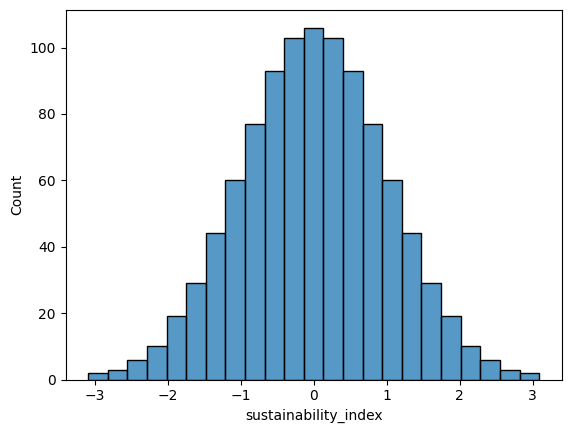

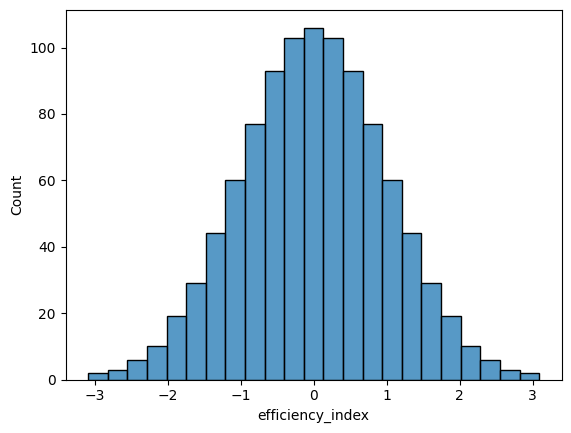

In [5]:
sns.histplot(df['sustainability_index'])
plt.show()

sns.histplot(df['efficiency_index'])
plt.show()

In [6]:
# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())



Missing Values in Each Column:
Celestial Body             0
distance_from_earth        0
iron                       0
nickel                     0
water_ice                  0
other_minerals             0
Estimated Value (B USD)    0
sustainability_index       0
efficiency_index           0
Potential Mining Site      0
dtype: int64


In [7]:
print("\nData Types:")
df.dtypes


Data Types:


Celestial Body              object
distance_from_earth        float64
iron                       float64
nickel                     float64
water_ice                  float64
other_minerals             float64
Estimated Value (B USD)    float64
sustainability_index       float64
efficiency_index           float64
Potential Mining Site         bool
dtype: object

In [8]:
# Check target variable distribution
print("\nTarget Variable Distribution:")
df['Potential Mining Site'].value_counts()


Target Variable Distribution:


Potential Mining Site
False    671
True     328
Name: count, dtype: int64

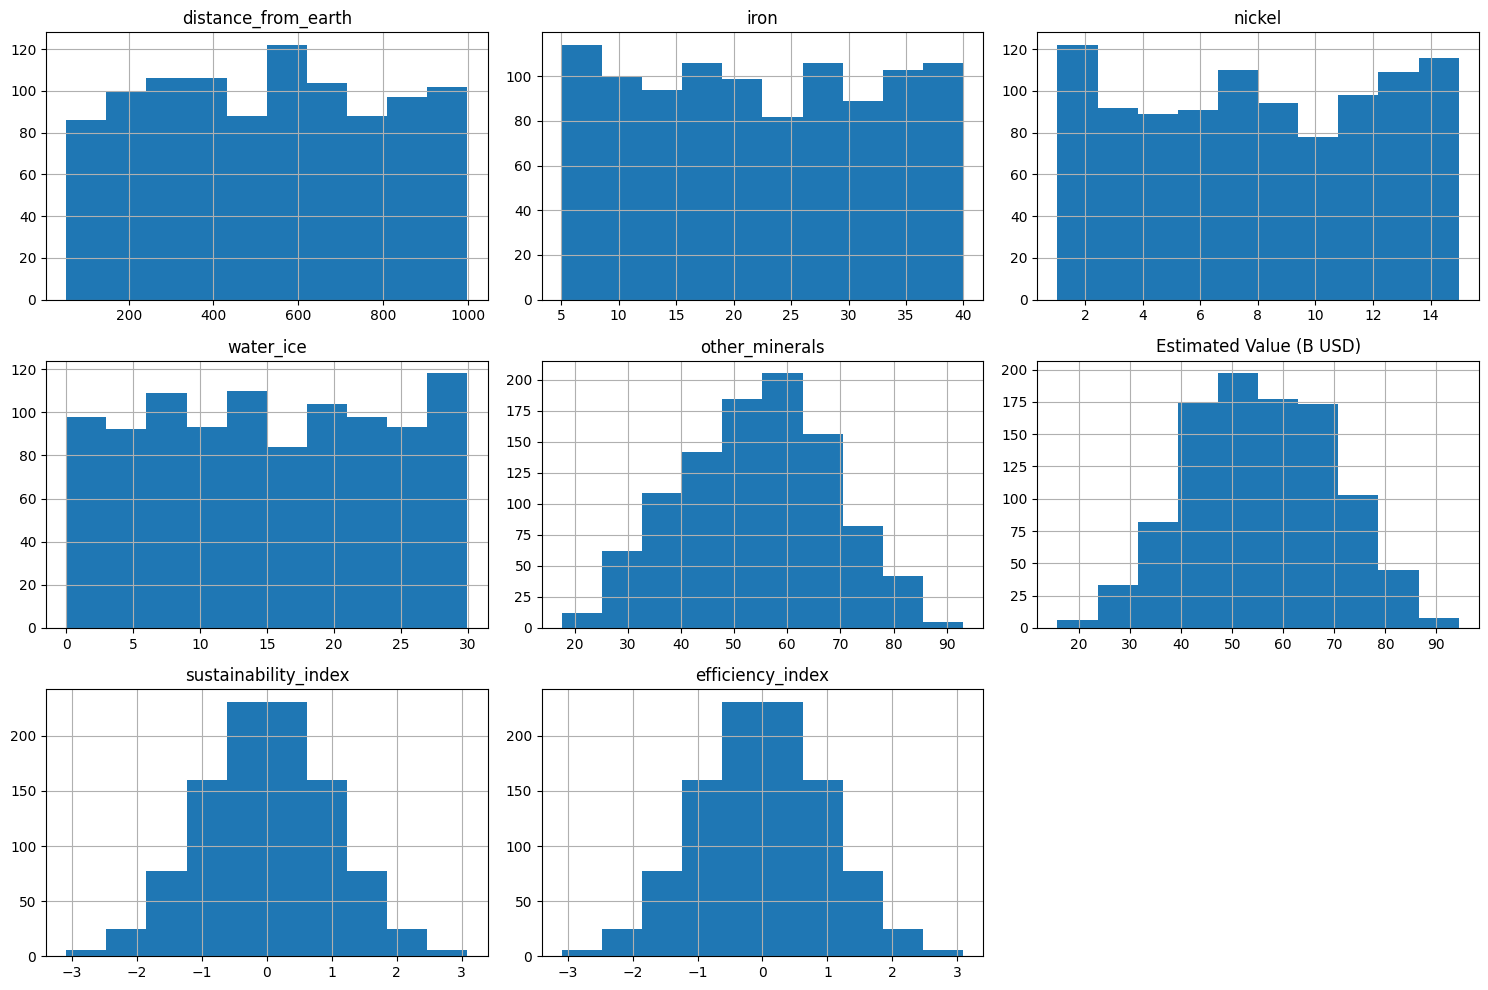

In [18]:

df.replace([np.inf, -np.inf], np.nan, inplace=True)

df.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()


In [9]:
df

Celestial Body  distance_from_earth       iron     nickel  water_ice  \
0           Europa           642.933081  11.483867   1.994606   6.678221   
1         Ganymede           472.073374  15.689480  10.364329  10.845723   
2             Mars           849.155224   7.381894   1.740230  19.694838   
3         Ganymede           359.054825  25.820767  11.145742   3.170590   
4         Ganymede           777.456918   7.600523   7.908855  13.765708   
..             ...                  ...        ...        ...        ...   
994       Ganymede           771.544946  26.106026   6.946919  20.686556   
995           Moon           747.935078  24.729005  12.930013  23.365134   
996       Asteroid           185.137211  33.480808  14.497638   4.336363   
997       Asteroid           643.267257  33.008416  14.027449  29.492347   
998         Europa           869.327550  39.123642   8.498080  23.544723   

     other_minerals  Estimated Value (B USD)  sustainability_index  \
0         79.843306                44.829297              0.185480   
1         63.100468                33.240823             -1.315958   
2         71.183038                54.211806             -0.627196   
3         59.862900                65.193925             -0.573115   
4         70.724915                65.507641             -1.694923   
..              ...                      ...                   ...   
994       46.260498                54.157023              0.651824   
995       38.975849                76.251103              0.642543   
996       47.685190                66.626664             -1.513589   
997       23.471787                57.643432              0.013801   
998       28.833556                50.522872              0.071571   

     efficiency_index  Potential Mining Site  
0           -0.011291                   True  
1            0.605955                  False  
2            0.403356                  False  
3            0.392492                  False  
4           -1.705570                  False  
..                ...                    ...  
994          1.135284                   True  
995         -1.994971                  False  
996         -1.275302                  False  
997          0.422483                   True  
998          1.684464                   True  

[999 rows x 10 columns]

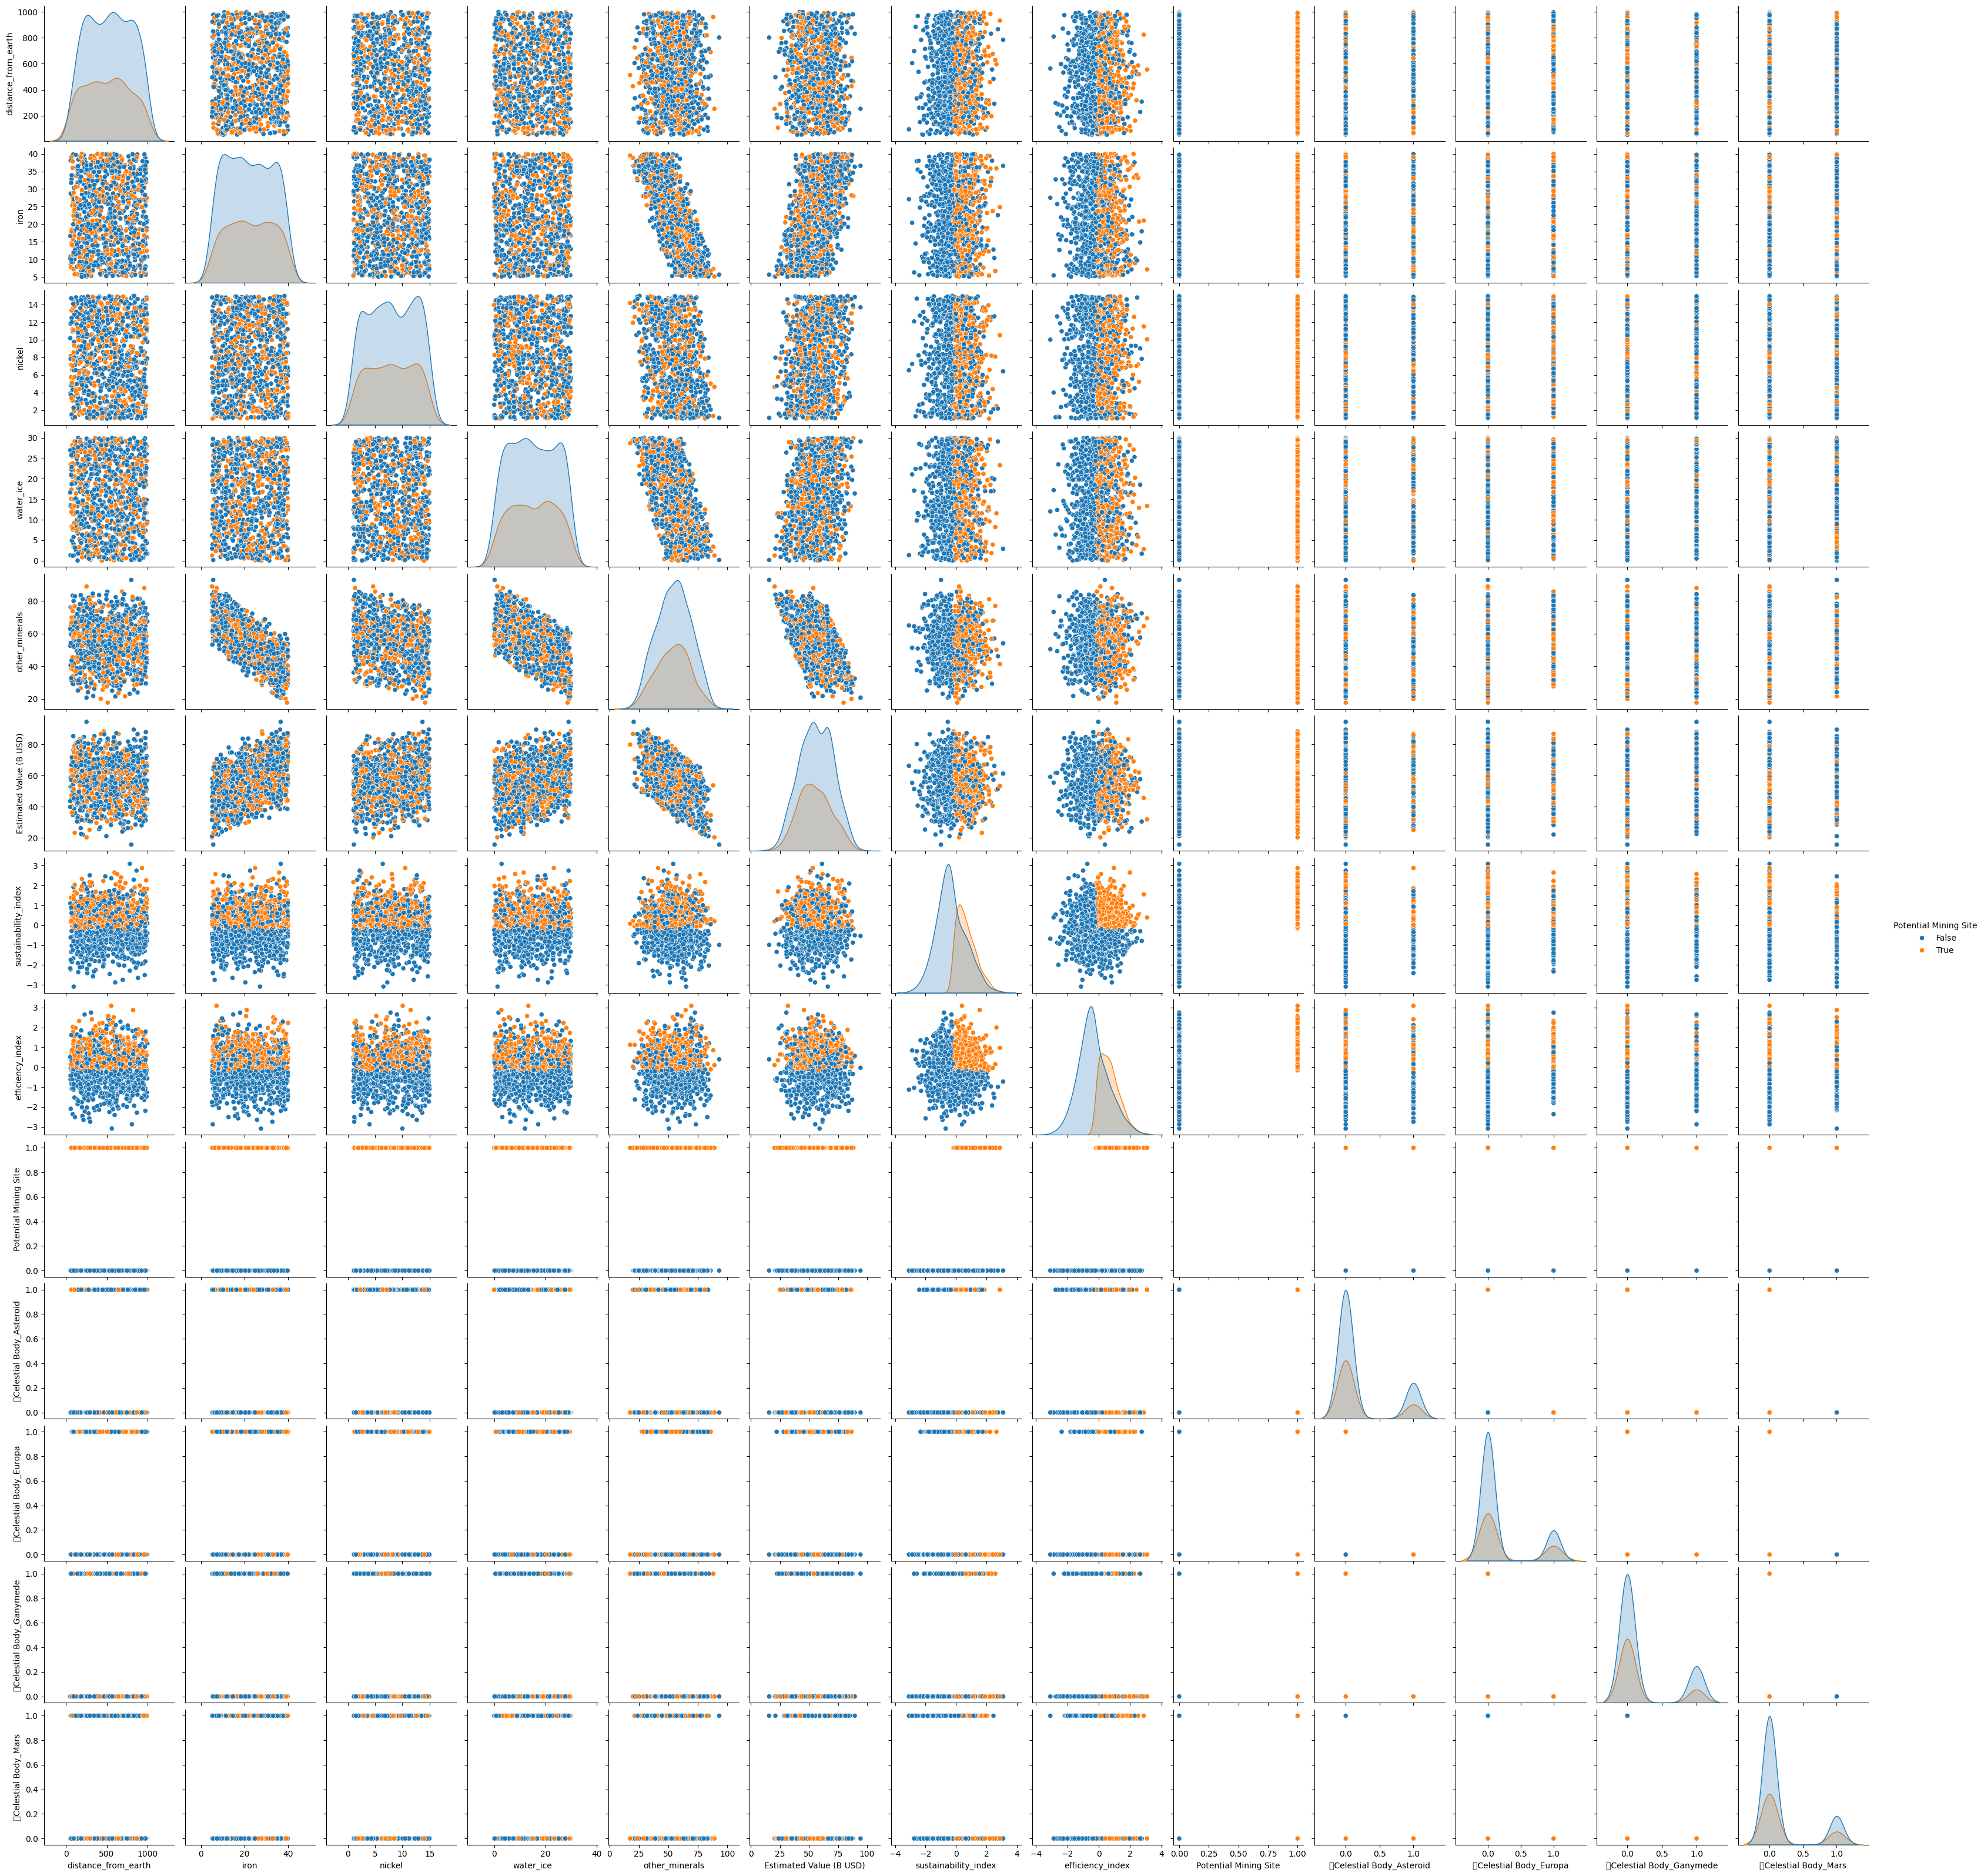

In [22]:
# Pairplot to visualize relationships
sns.pairplot(df, hue='Potential Mining Site', vars=df.columns[:-1])
plt.show()



In [33]:



X = df.drop(['Potential Mining Site'], axis=1)
y = df['Potential Mining Site']

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)


X.dropna(inplace=True)
y = y[X.index]


X.reset_index(drop=True, inplace=True)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [35]:
# Calculate class weights
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(zip(np.unique(y_train), class_weights))
print("\nClass Weights:", class_weights)



Class Weights: {False: 0.7448598130841122, True: 1.5209923664122138}


In [51]:

import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop

# Define the objective function for Optuna
def objective(trial):
    # Suggest values for the number of units in each layer
    n_units_1 = trial.suggest_int('n_units_1', 64, 256)
    n_units_2 = trial.suggest_int('n_units_2', 32, 128)

    # Suggest a dropout rate
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # Suggest optimizer
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])

    # Suggest learning rate
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)

    # Build the model
    model = Sequential()
    model.add(Dense(n_units_1, activation='relu', input_dim=x_train.shape[1]))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_units_2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Convert labels to numerical form
    y_train_res_encoded = y_train.apply(lambda x: 1 if x else 0)
    y_test_encoded = y_test.apply(lambda x: 1 if x else 0)

    # Train the model
    history = model.fit(
        x_train, y_train_res_encoded,
        epochs=trial.suggest_int('epochs', 50, 100),
        batch_size=trial.suggest_categorical('batch_size', [32, 64, 128, 256]),
        validation_data=(x_test, y_test_encoded),
        verbose=0
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(x_test, y_test_encoded, verbose=0)

    # Return the accuracy (maximize this)
    return accuracy

# Create a study object and specify to maximize accuracy
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=20)

# Print the best hyperparameters
print('Best Hyperparameters:', study.best_trial.params)


[I 2024-10-02 17:21:24,401] A new study created in memory with name: no-name-b66609f8-8a19-45bb-b3f8-a29a79c12f7a
[I 2024-10-02 17:21:37,667] Trial 0 finished with value: 0.824999988079071 and parameters: {'n_units_1': 237, 'n_units_2': 116, 'dropout_rate': 0.3030192349765691, 'optimizer': 'rmsprop', 'learning_rate': 1.3847753714526087e-05, 'epochs': 77, 'batch_size': 64}. Best is trial 0 with value: 0.824999988079071.
[I 2024-10-02 17:21:51,123] Trial 1 finished with value: 0.9800000190734863 and parameters: {'n_units_1': 160, 'n_units_2': 114, 'dropout_rate': 0.2606756625117499, 'optimizer': 'adam', 'learning_rate': 0.0006337626408972207, 'epochs': 77, 'batch_size': 64}. Best is trial 1 with value: 0.9800000190734863.
[I 2024-10-02 17:21:59,085] Trial 2 finished with value: 0.8849999904632568 and parameters: {'n_units_1': 102, 'n_units_2': 93, 'dropout_rate': 0.34146154716143773, 'optimizer': 'rmsprop', 'learning_rate': 0.0002075231143854368, 'epochs': 62, 'batch_size': 256}. Best is

Best Hyperparameters: {'n_units_1': 160, 'n_units_2': 114, 'dropout_rate': 0.2606756625117499, 'optimizer': 'adam', 'learning_rate': 0.0006337626408972207, 'epochs': 77, 'batch_size': 64}


In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build the model
model = Sequential()
model.add(Dense(160, activation='relu', input_dim=x_train.shape[1]))
model.add(Dropout(0.2606756625117499))
model.add(Dense(114, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.0006841395868750373)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Convert labels to numerical form
y_train_res_encoded = y_train.apply(lambda x: 1 if x else 0)
y_test_encoded = y_test.apply(lambda x: 1 if x else 0)

# Train the model
history = model.fit(
    x_train, y_train_res_encoded,
    epochs=77,
    batch_size=64,
    validation_data=(x_test, y_test_encoded),
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test_encoded)
print(f"Neural Network Accuracy: {accuracy:.4f}")


Epoch 1/77
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5866 - loss: 0.6473 - val_accuracy: 0.7050 - val_loss: 0.5233
Epoch 2/77
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7317 - loss: 0.4969 - val_accuracy: 0.8650 - val_loss: 0.3998
Epoch 3/77
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8152 - loss: 0.4224 - val_accuracy: 0.9000 - val_loss: 0.3203
Epoch 4/77
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8707 - loss: 0.3211 - val_accuracy: 0.8900 - val_loss: 0.2693
Epoch 5/77
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8723 - loss: 0.3029 - val_accuracy: 0.9050 - val_loss: 0.2393
Epoch 6/77
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8859 - loss: 0.2739 - val_accuracy: 0.9000 - val_loss: 0.2242
Epoch 7/77
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8754 - loss: 0.2594 - val_accuracy: 0.9150 - val_loss: 0.2110
Epoch 8/77
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8903 - loss: 0.2422 - val_accuracy: 0.9300 - v

In [60]:


y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Convert y_test to numerical form for evaluation
y_test_encoded = y_test.apply(lambda x: 1 if x else 0)


# Evaluate the model
print(classification_report(y_test_encoded, y_pred))
print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test_encoded, y_pred_prob)
print("ROC AUC Score:", roc_auc)



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       134
           1       0.98      0.92      0.95        66

    accuracy                           0.97       200
   macro avg       0.97      0.96      0.97       200
weighted avg       0.97      0.97      0.97       200

Accuracy: 0.97
Confusion Matrix:
 [[133   1]
 [  5  61]]
ROC AUC Score: 0.9963817277250113


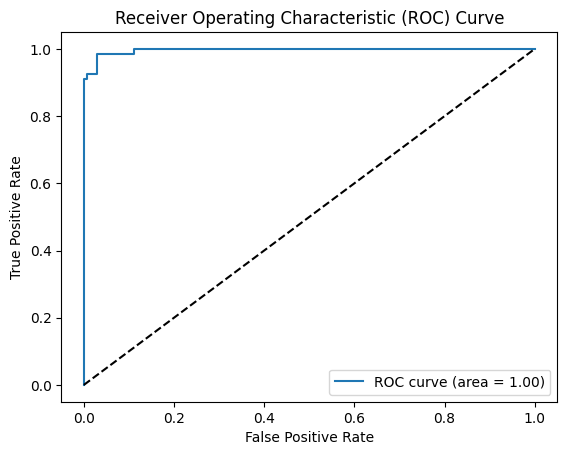

In [61]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_prob)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()




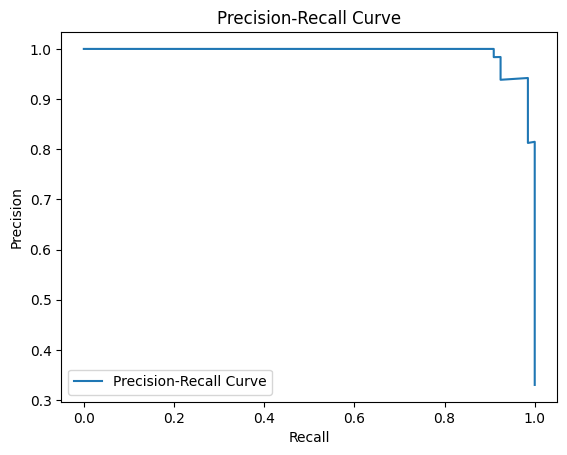

In [62]:
 #Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_encoded, y_pred_prob)
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

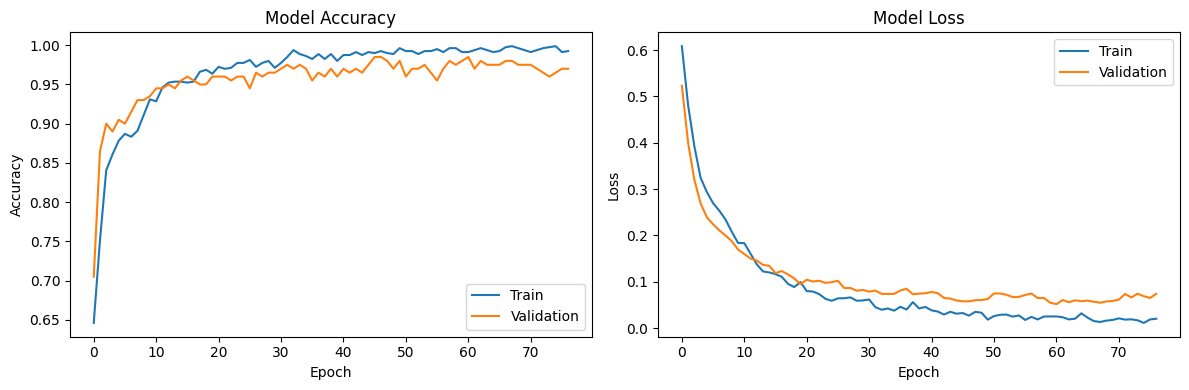

In [59]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

